<a href="https://colab.research.google.com/github/Tomer-TK/skills-introduction-to-github/blob/main/Statistical_Theory_TR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Stage 1 — Kaggle setup
!pip -q install kaggle

from google.colab import files
import os, json, zipfile

print("👉 Please upload your kaggle.json (Kaggle -> Account -> Create API Token)")
uploaded = files.upload()  # choose kaggle.json

os.makedirs("/root/.kaggle", exist_ok=True)
with open("kaggle.json", "wb") as f:
    f.write(uploaded["kaggle.json"])
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle --version



👉 Please upload your kaggle.json (Kaggle -> Account -> Create API Token)


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5
✅ Kaggle API set.


In [ ]:

# Stage 2 — Download dataset - Match Charting Project (Men)

!kaggle datasets download -d ryanthomasallen/tennis-match-charting-project -p /content/data -q
os.makedirs("/content/data", exist_ok=True)

# Unzip
with zipfile.ZipFile("/content/data/tennis-match-charting-project.zip", 'r') as z:
    z.extractall("/content/data/mcp")

!ls -lah /content/data/mcp | head -n 50



Dataset URL: https://www.kaggle.com/datasets/ryanthomasallen/tennis-match-charting-project
License(s): CC-BY-NC-SA-4.0
total 230M
drwxr-xr-x 2 root root 4.0K Oct 22 09:31 .
drwxr-xr-x 3 root root 4.0K Oct 22 09:30 ..
-rw-r--r-- 1 root root 304K Oct 22 09:32 charting-m-matches.csv
-rw-r--r-- 1 root root  77M Oct 22 09:32 charting-m-points.csv
-rw-r--r-- 1 root root 1.3M Oct 22 09:32 charting-m-stats-KeyPointsReturn.csv
-rw-r--r-- 1 root root 1.4M Oct 22 09:32 charting-m-stats-KeyPointsServe.csv
-rw-r--r-- 1 root root 1.5M Oct 22 09:32 charting-m-stats-NetPoints.csv
-rw-r--r-- 1 root root 1.5M Oct 22 09:32 charting-m-stats-Overview.csv
-rw-r--r-- 1 root root 2.3M Oct 22 09:32 charting-m-stats-Rally.csv
-rw-r--r-- 1 root root 6.1M Oct 22 09:32 charting-m-stats-ReturnDepth.csv
-rw-r--r-- 1 root root 7.2M Oct 22 09:32 charting-m-stats-ReturnOutcomes.csv
-rw-r--r-- 1 root root 1.1M Oct 22 09:32 charting-m-stats-ServeBasics.csv
-rw-r--r-- 1 root root 1.1M Oct 22 09:32 charting-m-stats-ServeDi

In [ ]:
# Stage 3 — Load
import pandas as pd
import numpy as np

# Helper: robust CSV loader for slightly malformed CSVs
def read_csv_robust(path, usecols=None):
    # engine="python" + on_bad_lines to survive quotes/newlines in fields
    return pd.read_csv(
        path,
        engine="python",
        encoding="latin1",
        on_bad_lines="skip",
        usecols=usecols
    )

# Files we expect (men):
matches_path = "/content/data/mcp/charting-m-matches.csv"
points_path  = "/content/data/mcp/charting-m-points.csv"

# Load only the columns we really need
matches = read_csv_robust(
    matches_path,
    usecols=["match_id", "Surface", "Gender", "Tournament", "Date"]
)

# rallyCount is the shots per point (rally length)
# Set/Game columns sometimes vary; we only keep rallyCount + match_id here
points = read_csv_robust(
    points_path,
    usecols=["match_id", "rallyCount"]
)

# Standardize column names (just in case)
matches.columns = matches.columns.str.strip()
points.columns  = points.columns.str.strip()

print(matches.head(3))
print(points.head(3))

                                            match_id Gender      Date  \
0  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...      M  20180520   
1  20180519-M-Rome_Masters-SF-Rafael_Nadal-Novak_...      M  20180519   
2  20180519-M-Rome_Masters-SF-Marin_Cilic-Alexand...      M  20180519   

     Tournament Surface  
0  Rome Masters    Clay  
1  Rome Masters    Clay  
2  Rome Masters    Clay  
                                            match_id rallyCount
0  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...          6
1  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...         16
2  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...          6
✅ Loaded core files.


In [ ]:

# Stage 4 — Clean + merge
# Keep only valid rallyCount (numeric)
points = points.dropna(subset=["rallyCount"]).copy()
# Sometimes rallyCount sneaks in as strings; coerce to numeric
points["rallyCount"] = pd.to_numeric(points["rallyCount"], errors="coerce")
points = points.dropna(subset=["rallyCount"]).copy()
points["rallyCount"] = points["rallyCount"].astype(int)

# Clean matches
matches = matches.dropna(subset=["match_id", "Surface"]).copy()
# Keep only main surfaces
valid_surfaces = {"Clay", "Grass", "Hard"}
matches = matches[matches["Surface"].isin(valid_surfaces)].copy()

# Parse year (optional)
def parse_year(val):
    # The Date in MCP is often like 20180520; robustly keep first 4 chars
    s = str(val)
    return int(s[:4]) if s and s[:4].isdigit() else np.nan

matches["Year"] = matches["Date"].apply(parse_year)

# Merge
df = points.merge(matches, on="match_id", how="inner")

# Final tidy columns
df = df[["match_id", "Surface", "Gender", "Year", "rallyCount"]].rename(
    columns={"rallyCount": "rally_length"}
)

# Basic sanity filters
df = df[df["rally_length"] >= 1].copy()           # remove 0/negatives if any
df = df.dropna(subset=["Surface", "Gender"])      # keep complete rows

print(df.head(10))
print(df.shape, df["Surface"].value_counts(dropna=False))


                                            match_id Surface Gender  Year  \
0  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
1  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
2  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
3  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
4  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
5  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
6  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
7  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
8  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   
9  20180520-M-Rome_Masters-F-Rafael_Nadal-Alexand...    Clay      M  2018   

   rally_length  
0             6  
1            16  
2             6  
3             1  
4             9  
5            20  
6            12  
7       

In [ ]:
# Stage 5 — Save for reuse

out_path = "/content/tennis_rallies_clean.csv"
df.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: /content/tennis_rallies_clean.csv


In [ ]:

# Stage 6 — First summaries (RQ1/RQ2 prep)

# Summary by surface
summary = df.groupby("Surface")["rally_length"].describe().round(3)
overall  = df["rally_length"].describe().round(3)

print("=== Overall rally length summary ===")
print(overall, "\n")
print("=== Rally length by surface ===")
print(summary)

# Quick dispersion check: variance vs mean (Poisson expects Var ≈ Mean)
dispersion = df.groupby("Surface")["rally_length"].agg(["mean","var"])
dispersion["var/mean"] = dispersion["var"] / dispersion["mean"]
print("\n=== Dispersion by surface (var/mean) ===")
print(dispersion.round(3))


=== Overall rally length summary ===
count    188007.000
mean          4.367
std           4.195
min           1.000
25%           1.000
50%           3.000
75%           6.000
max          85.000
Name: rally_length, dtype: float64 

=== Rally length by surface ===
            count   mean    std  min  25%  50%  75%   max
Surface                                                  
Clay      54420.0  5.041  4.663  1.0  2.0  4.0  7.0  85.0
Grass     22321.0  3.289  3.016  1.0  1.0  3.0  4.0  37.0
Hard     111266.0  4.254  4.100  1.0  1.0  3.0  6.0  57.0

=== Dispersion by surface (var/mean) ===
          mean     var  var/mean
Surface                         
Clay     5.041  21.745     4.313
Grass    3.289   9.098     2.766
Hard     4.254  16.812     3.952


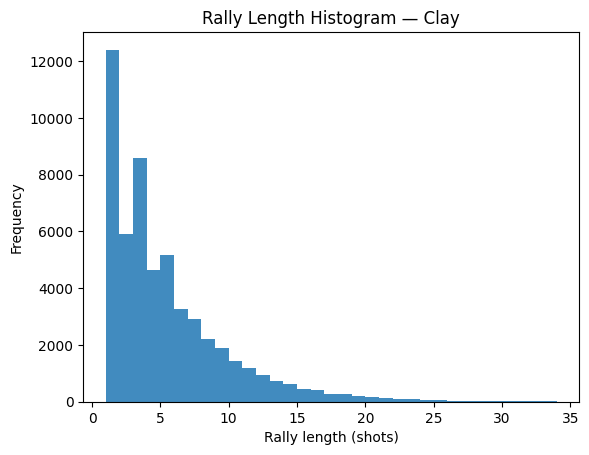

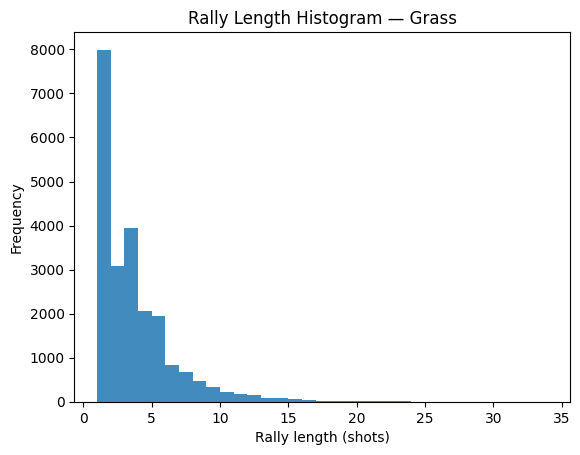

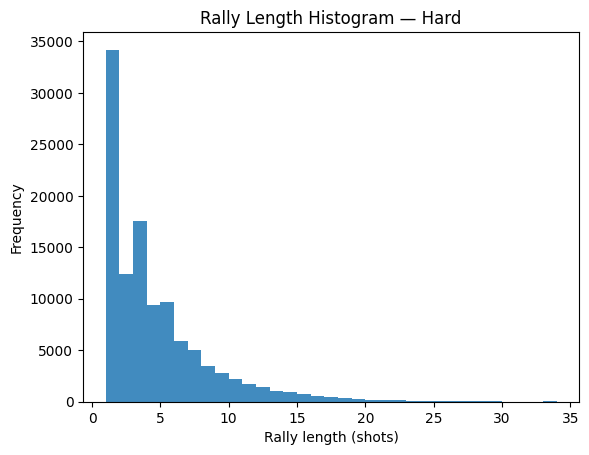

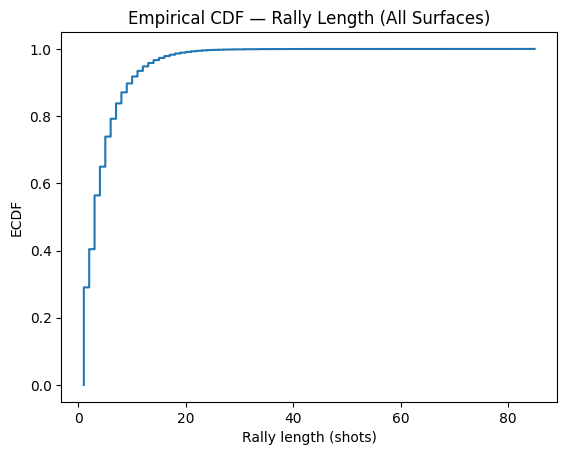

In [ ]:
# Stage 7 — Simple plots for distributional shape

import matplotlib.pyplot as plt

# Histogram by surface (separate figures)
for s in sorted(df["Surface"].unique()):
    subset = df.loc[df["Surface"]==s, "rally_length"]
    plt.figure()
    plt.hist(subset, bins=range(1, 35), alpha=0.85)
    plt.title(f"Rally Length Histogram — {s}")
    plt.xlabel("Rally length (shots)")
    plt.ylabel("Frequency")
    plt.show()

# Empirical CDF (overall)
x = np.sort(df["rally_length"].values)
y = np.arange(1, len(x)+1) / len(x)
plt.figure()
plt.step(x, y, where="post")
plt.title("Empirical CDF — Rally Length (All Surfaces)")
plt.xlabel("Rally length (shots)")
plt.ylabel("ECDF")
plt.show()


In [ ]:

# Stage 8 — Quick Poisson vs NB fit (starter)
# We'll use statsmodels for a quick check; formal GLRT to come later
!pip -q install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1) Poisson regression (intercept only) ~ mean rate
poisson_model = smf.glm("rally_length ~ 1", data=df, family=sm.families.Poisson()).fit()
print("=== Poisson (intercept-only) ===")
print(poisson_model.summary())

# 2) Negative Binomial regression (intercept only)
# Note: statsmodels NB uses log link + ancillary parameter; good for overdispersion
nb_model = smf.glm("rally_length ~ 1", data=df, family=sm.families.NegativeBinomial()).fit()
print("\n=== Negative Binomial (intercept-only) ===")
print(nb_model.summary())

# 3) Compare AIC/BIC as a first pass
print("\n=== AIC/BIC comparison (lower is better) ===")
print({
    "Poisson_AIC": poisson_model.aic,
    "Poisson_BIC": poisson_model.bic if hasattr(poisson_model, "bic") else np.nan,
    "NB_AIC": nb_model.aic,
    "NB_BIC": nb_model.bic if hasattr(nb_model, "bic") else np.nan
})


=== Poisson (intercept-only) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           rally_length   No. Observations:               188007
Model:                            GLM   Df Residuals:                   188006
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.7917e+05
Date:                Wed, 22 Oct 2025   Deviance:                   5.9253e+05
Time:                        09:33:06   Pearson chi2:                 7.58e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.47

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



=== Negative Binomial (intercept-only) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           rally_length   No. Observations:               188007
Model:                            GLM   Df Residuals:                   188006
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.8520e+05
Date:                Wed, 22 Oct 2025   Deviance:                   1.0989e+05
Time:                        09:33:07   Pearson chi2:                 1.41e+05
No. Iterations:                     5   Pseudo R-squ. (CS):          1.221e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [ ]:
# Stage 9 — Clay vs Grass

# Subset to Clay and Grass
cg = df[df["Surface"].isin(["Clay","Grass"])].copy()

# Simple Poisson regression with surface as a factor
model_surface_pois = smf.glm("rally_length ~ C(Surface)", data=cg, family=sm.families.Poisson()).fit()
print("=== Poisson GLM: rally_length ~ Surface ===")
print(model_surface_pois.summary())
print("Rate ratio (Clay vs Grass) ≈ exp(beta):", np.exp(model_surface_pois.params.get("C(Surface)[T.Grass]", 0)) )

# NB version
model_surface_nb = smf.glm("rally_length ~ C(Surface)", data=cg, family=sm.families.NegativeBinomial()).fit()
print("\n=== NB GLM: rally_length ~ Surface ===")
print(model_surface_nb.summary())
print("Rate ratio (Clay vs Grass) ≈ exp(beta):", np.exp(model_surface_nb.params.get("C(Surface)[T.Grass]", 0)) )


=== Poisson GLM: rally_length ~ Surface ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           rally_length   No. Observations:                76741
Model:                            GLM   Df Residuals:                    76739
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3436e+05
Date:                Wed, 22 Oct 2025   Deviance:                   2.3466e+05
Time:                        09:33:08   Pearson chi2:                 2.96e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1384
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



=== NB GLM: rally_length ~ Surface ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           rally_length   No. Observations:                76741
Model:                            GLM   Df Residuals:                    76739
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9951e+05
Date:                Wed, 22 Oct 2025   Deviance:                       42183.
Time:                        09:33:08   Pearson chi2:                 5.33e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02809
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [ ]:

# Stage 10 — One-sided hypothesis via Wald on rate ratio
# H0: lambda_clay = lambda_grass  vs  H1: lambda_clay > lambda_grass
# With GLM coding, Grass may be baseline; adjust contrast accordingly.

# If "Grass" is baseline, the coefficient for C(Surface)[T.Clay] tests Clay vs Grass directly.
# Re-fit with Grass as baseline explicitly.
cg["Surface"] = pd.Categorical(cg["Surface"], categories=["Grass","Clay"])
model_surface_nb2 = smf.glm("rally_length ~ C(Surface)", data=cg, family=sm.families.NegativeBinomial()).fit()
print(model_surface_nb2.summary())

beta = model_surface_nb2.params["C(Surface)[T.Clay]"]
se   = model_surface_nb2.bse["C(Surface)[T.Clay]"]
z    = beta / se
from mpmath import quad, exp
import math
# one-sided p-value (H1: Clay > Grass) using standard normal tail
from math import erf, sqrt
def norm_cdf(z): return 0.5*(1+erf(z/sqrt(2)))
p_one_sided = 1 - norm_cdf(z) if z>0 else 1.0  # conservative
print(f"\nOne-sided Wald z for (Clay > Grass): z={z:.3f}, p≈{p_one_sided:.4f}, rate ratio≈{math.exp(beta):.3f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:           rally_length   No. Observations:                76741
Model:                            GLM   Df Residuals:                    76739
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9951e+05
Date:                Wed, 22 Oct 2025   Deviance:                       42183.
Time:                        09:33:09   Pearson chi2:                 5.33e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02809
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1905      0

In [ ]:
# Stage 11 — Report-ready numbers
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# If df / models exist from earlier cells, great; otherwise (re)define them quickly:
try:
    df
except NameError:
    # If you restarted runtime, reload your cleaned file:
    df = pd.read_csv("/content/tennis_rallies_clean.csv")

# Intercept-only Poisson & NB for RQ1 (re-fit here to be self-contained)
poisson_model = smf.glm("rally_length ~ 1", data=df, family=sm.families.Poisson()).fit()
nb_model      = smf.glm("rally_length ~ 1", data=df, family=sm.families.NegativeBinomial()).fit()

mean_all = df["rally_length"].mean()
var_all  = df["rally_length"].var(ddof=1)
vmr      = var_all / mean_all

LR       = 2*(nb_model.llf - poisson_model.llf)
pval_LR  = 1 - stats.chi2.cdf(LR, df=1)

# Clay vs Grass subset (Grass baseline already set in Stage 10)
cg = df[df["Surface"].isin(["Clay","Grass"])].copy()
cg["Surface"] = pd.Categorical(cg["Surface"], categories=["Grass","Clay"])
model_surface_nb2 = smf.glm("rally_length ~ C(Surface)", data=cg, family=sm.families.NegativeBinomial()).fit()

beta = model_surface_nb2.params["C(Surface)[T.Clay]"]
se   = model_surface_nb2.bse["C(Surface)[T.Clay]"]
z    = beta / se
p_one_sided = 1 - stats.norm.cdf(z) if z > 0 else 1.0
rate_ratio  = float(np.exp(beta))
ci_low, ci_high = np.exp([beta - 1.96*se, beta + 1.96*se])

means_by_surface = cg.groupby("Surface")["rally_length"].mean()

print("=== RQ1: Distributional Fit (All surfaces) ===")
print(f"Mean rally length: {mean_all:.3f}")
print(f"Variance: {var_all:.3f}")
print(f"Variance/Mean ratio: {vmr:.3f}")
print(f"Likelihood Ratio Test (Poisson vs NB): LR = {LR:.3f}, p = {pval_LR:.3e}")
print(f"AIC Poisson: {poisson_model.aic:.2f}, AIC NB: {nb_model.aic:.2f}")

print("\n=== RQ2: Clay vs Grass ===")
print(f"Mean (Grass): {means_by_surface['Grass']:.3f}")
print(f"Mean (Clay):  {means_by_surface['Clay']:.3f}")
print(f"Rate ratio (Clay/Grass): {rate_ratio:.3f}")
print(f"95% CI for RR: ({ci_low:.3f}, {ci_high:.3f})")
print(f"Wald z (one-sided for Clay>Grass): {z:.3f}, p = {p_one_sided:.3e}")


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


=== RQ1: Distributional Fit (All surfaces) ===
Mean rally length: 4.367
Variance: 17.602
Variance/Mean ratio: 4.030
Likelihood Ratio Test (Poisson vs NB): LR = 187941.350, p = 0.000e+00
AIC Poisson: 1158349.65, AIC NB: 970408.30

=== RQ2: Clay vs Grass ===
Mean (Grass): 3.289
Mean (Clay):  5.041
Rate ratio (Clay/Grass): 1.533
95% CI for RR: (1.506, 1.560)
Wald z (one-sided for Clay>Grass): 47.627, p = 0.000e+00


/tmp/ipython-input-4185088538.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_by_surface = cg.groupby("Surface")["rally_length"].mean()


In [ ]:
# Stage 12 — Chi-square GOF for Poisson

import numpy as np
from scipy import stats

# Bin rally lengths up to max_len-1, and lump the tail into the last bin
max_len = 20
counts = df["rally_length"].clip(upper=max_len).value_counts().sort_index()

# Ensure we have bins from 1..max_len
idx = np.arange(1, max_len+1)
obs = np.array([counts.get(k, 0) for k in idx])

# Expected under Poisson with lambda = mean_all
lam = mean_all
probs = stats.poisson.pmf(idx[:-1], lam)
tail_prob = 1 - stats.poisson.cdf(max_len-1, lam)
probs = np.append(probs, tail_prob)

expct = probs * len(df)

# Combine bins with very small expected counts if needed (rule of thumb)
# (Simple version: proceed as is; for very small exp bins consider merging manually)
chi2 = ((obs - expct)**2 / expct).sum()
df_gof = len(obs) - 2  # estimated lambda + total probability constraint
p_gof = 1 - stats.chi2.cdf(chi2, df=df_gof)

print(f"Chi-square GOF (Poisson): statistic = {chi2:.2f}, df = {df_gof}, p = {p_gof:.3e}")


Chi-square GOF (Poisson): statistic = 554379066.01, df = 18, p = 0.000e+00


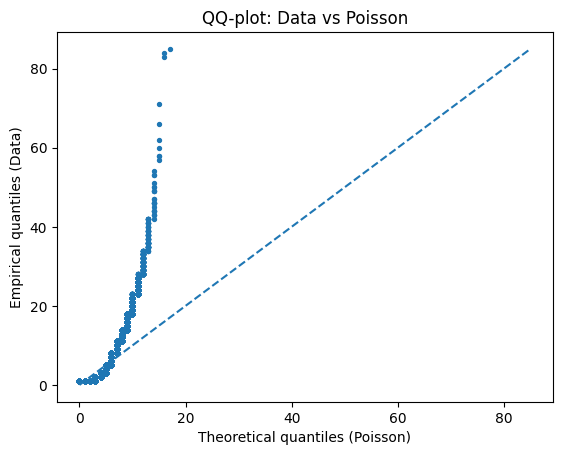

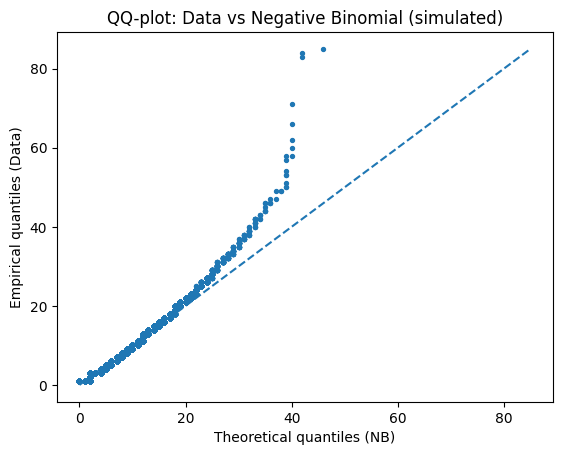

In [ ]:
# Stage 13 — QQ-plots: Data vs Poisson, Data vs NB

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = np.sort(df["rally_length"].values)
n = len(data)
probs = (np.arange(1, n+1) - 0.5) / n

# Theoretical Poisson quantiles
pois_q = stats.poisson.ppf(probs, mean_all)

# For NB, estimate r and p from sample mean/variance (method of moments):
# NB with parameters (r, p) has mean = r*(1-p)/p and var = r*(1-p)/p^2
# Solve for r, p given sample mean m and variance v (v>m):
m = mean_all
v = var_all
if v > m + 1e-9:
    r_est = m**2 / (v - m)
    p_est = r_est / (r_est + m)
    # Simulated NB sample to get NB quantiles with same size as data
    nb_sample = stats.nbinom.rvs(r_est, p_est, size=n, random_state=123)
    nb_q = np.sort(nb_sample)
else:
    r_est, p_est = np.nan, np.nan
    nb_q = np.copy(pois_q)  # fallback

# Plot QQ: Data vs Poisson
plt.figure()
plt.scatter(pois_q, data, s=8)
plt.plot([min(pois_q.min(), data.min()), max(pois_q.max(), data.max())],
         [min(pois_q.min(), data.min()), max(pois_q.max(), data.max())], linestyle="--")
plt.title("QQ-plot: Data vs Poisson")
plt.xlabel("Theoretical quantiles (Poisson)")
plt.ylabel("Empirical quantiles (Data)")
plt.show()

# Plot QQ: Data vs NB (simulated quantiles)
plt.figure()
plt.scatter(nb_q, data, s=8)
plt.plot([min(nb_q.min(), data.min()), max(nb_q.max(), data.max())],
         [min(nb_q.min(), data.min()), max(nb_q.max(), data.max())], linestyle="--")
plt.title("QQ-plot: Data vs Negative Binomial (simulated)")
plt.xlabel("Theoretical quantiles (NB)")
plt.ylabel("Empirical quantiles (Data)")
plt.show()


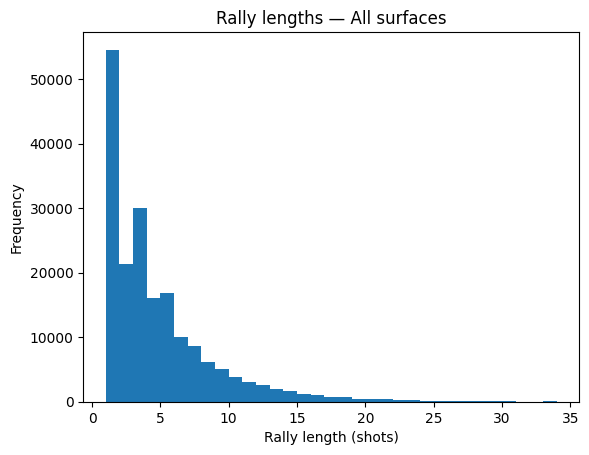

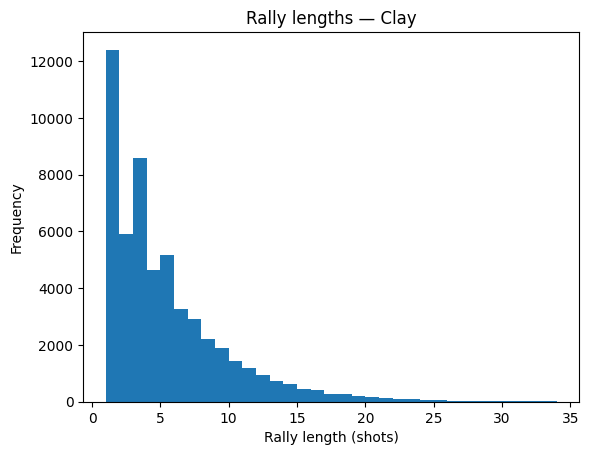

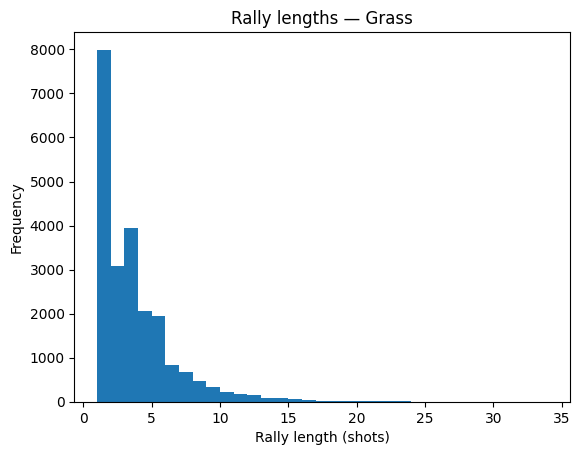

In [ ]:

# Stage 14 — Histograms

import matplotlib.pyplot as plt
import numpy as np

# Overall histogram
plt.figure()
plt.hist(df["rally_length"], bins=range(1, 35), density=False)
plt.title("Rally lengths — All surfaces")
plt.xlabel("Rally length (shots)")
plt.ylabel("Frequency")
plt.show()

# Clay-only histogram
plt.figure()
plt.hist(df.loc[df["Surface"]=="Clay", "rally_length"], bins=range(1, 35), density=False)
plt.title("Rally lengths — Clay")
plt.xlabel("Rally length (shots)")
plt.ylabel("Frequency")
plt.show()

# Grass-only histogram
plt.figure()
plt.hist(df.loc[df["Surface"]=="Grass", "rally_length"], bins=range(1, 35), density=False)
plt.title("Rally lengths — Grass")
plt.xlabel("Rally length (shots)")
plt.ylabel("Frequency")
plt.show()


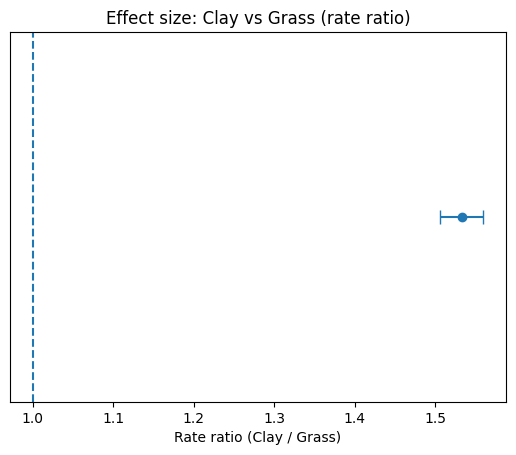

In [ ]:
# Stage 15 — Effect size (rate ratio with 95% CI)

import matplotlib.pyplot as plt
import numpy as np

plt.figure()
center = rate_ratio
err_low  = center - ci_low
err_high = ci_high - center
plt.errorbar(x=center, y=0, xerr=[[err_low], [err_high]], fmt='o', capsize=5)
plt.axvline(1.0, linestyle="--")
plt.title("Effect size: Clay vs Grass (rate ratio)")
plt.xlabel("Rate ratio (Clay / Grass)")
plt.yticks([])
plt.show()


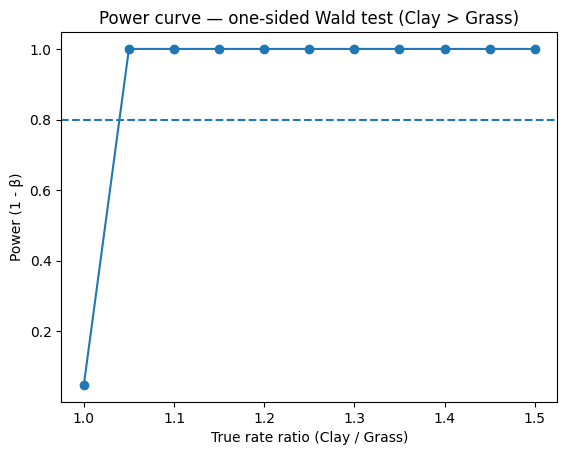

In [ ]:
# Stage 16 — Power curve for one-sided Wald test (Clay > Grass)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

n_clay  = int((cg["Surface"]=="Clay").sum())
n_grass = int((cg["Surface"]=="Grass").sum())
lambda_grass = cg.loc[cg["Surface"]=="Grass", "rally_length"].mean()

rr_grid = np.linspace(1.00, 1.50, 11)  # true rate ratios
power = []

for rr in rr_grid:
    lam_clay = lambda_grass * rr
    # Simple parametric simulation under Poisson means (conservative vs NB)
    reps, hits = 250, 0
    for _ in range(reps):
        g = np.random.poisson(lambda_grass, n_grass).mean()
        c = np.random.poisson(lam_clay, n_clay).mean()
        # Wald z for log rate ratio
        beta_hat = np.log(c/g)
        # Approximate SE using delta method: Var(log mean) ≈ 1/(n*mean)
        se_hat = np.sqrt(1/(n_clay*c) + 1/(n_grass*g))
        z_hat = beta_hat / se_hat
        if z_hat > stats.norm.ppf(0.95):  # one-sided alpha=0.05
            hits += 1
    power.append(hits / reps)

plt.figure()
plt.plot(rr_grid, power, marker="o")
plt.axhline(0.8, linestyle="--")
plt.title("Power curve — one-sided Wald test (Clay > Grass)")
plt.xlabel("True rate ratio (Clay / Grass)")
plt.ylabel("Power (1 - β)")
plt.show()
